In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from keras.callbacks import EarlyStopping
import tensorflow as tf
from keras.layers import Bidirectional
import keras_tuner as kt
from tensorflow.keras.optimizers import Adam, SGD
import os
from tensorflow.keras import backend as K
import gc
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import shap

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
# can check if you are using your GPU. 
# macOS users -> this will not work, you need to go through a great deal of pain to get it working

gpu_devices = tf.config.list_physical_devices('GPU')
if gpu_devices:
    print("GPU yes")
else:
    print("No GPU")

GPU yes


In [3]:
import matplotlib.pyplot as plt

In [4]:
big = pd.read_csv('/Users/lpaggen/Documents/DACS COURSES/Project2-2/Project_2-2/NL_data/train_set_1/big_data.csv')
# test_set = pd.read_csv('/Users/lpaggen/Documents/DACS COURSES/Project2-2/Project_2-2/NL_data/test_set/processed_data.csv')

Columns (18,19,20,21,22,23,24) have mixed types. Specify dtype option on import or set low_memory=False.


In [5]:
# due (i suppose) to the large size of the file, there was an issue with some dummy variables, we can fix it easily

nl_df = big.copy(deep = True) # do this otherwise we have very annoying issue

nl_df['time'] = pd.to_datetime(nl_df['time'])
affected_month_columns = ['month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12']
df_dummies = pd.get_dummies(nl_df['time'].dt.month, prefix = 'month', dummy_na = True)
nl_df[affected_month_columns] = df_dummies[['month_6.0', 'month_7.0', 'month_8.0', 'month_9.0', 'month_10.0', 'month_11.0', 'month_12.0']]
nl_df.set_index('time', inplace = True)
nl_df.sort_index(inplace = True)

# make some extra dummies which our models will use to situate themselves in time
nl_df['hour'] = nl_df.index.hour
nl_df['day'] = nl_df.index.day
nl_df = pd.get_dummies(nl_df, columns=['day', 'hour'], drop_first=True)

# can get all "major" cities df below
ams_df = nl_df[(nl_df['latitude'] == 52.25) & (nl_df['longitude'] == 5.)]
middelburg_df = nl_df[(nl_df['latitude'] == 51.50) & (nl_df['longitude'] == 3.5)]
hertogenbosch_df = nl_df[(nl_df['latitude'] == 51.75) & (nl_df['longitude'] == 5.5)]
maastricht_df = nl_df[(nl_df['latitude'] == 51.) & (nl_df['longitude'] == 5.75)]
utrecht_df = nl_df[(nl_df['latitude'] == 52.) & (nl_df['longitude'] == 5.)]
hague_df = nl_df[(nl_df['latitude'] == 52.) & (nl_df['longitude'] == 4.25)]
arnhem_df = nl_df[(nl_df['latitude'] == 52.) & (nl_df['longitude'] == 6.)]
lelystad_df = nl_df[(nl_df['latitude'] == 52.5) & (nl_df['longitude'] == 5.5)]
zwolle_df = nl_df[(nl_df['latitude'] == 52.5) & (nl_df['longitude'] == 6.)]
leeuwarden_df = nl_df[(nl_df['latitude'] == 53.25) & (nl_df['longitude'] == 5.75)]
assen_df = nl_df[(nl_df['latitude'] == 53.) & (nl_df['longitude'] == 6.5)]
groningen_df = nl_df[(nl_df['latitude'] == 53.25) & (nl_df['longitude'] == 6.5)]

ams_tr, ams_ts = ams_df.iloc[:125500], ams_df.iloc[125500:]
middelburg_tr, middelburg_ts = middelburg_df.iloc[:125500], middelburg_df.iloc[125500:]
hertogenbosch_tr, hertogenbosch_ts = hertogenbosch_df.iloc[:125500], hertogenbosch_df.iloc[125500:]
maastricht_tr, maastricht_ts = maastricht_df.iloc[:125500], maastricht_df.iloc[125500:]
utrecht_tr, utrecht_ts = utrecht_df.iloc[:125500], utrecht_df.iloc[125500:]
hague_tr, hague_ts = hague_df.iloc[:125500], hague_df.iloc[125500:]
arnhem_tr, arnhem_ts = arnhem_df.iloc[:125500], arnhem_df.iloc[125500:]
lelystad_tr, lelystad_ts = lelystad_df[:125500], lelystad_df[125500:]
zwolle_tr, zwolle_ts = zwolle_df[:125500], zwolle_df[125500:]
leeuwarden_tr, leeuwarden_ts = leeuwarden_df[:125500], leeuwarden_df[125500:]
assen_tr, assen_ts = assen_df[:125500], assen_df[125500:]
groningen_tr, groningen_ts = groningen_df.iloc[:125500], groningen_df.iloc[125500:]

In [6]:
dataframes_tr = [ams_tr, middelburg_tr, hertogenbosch_tr, maastricht_tr, utrecht_tr, hague_tr, arnhem_tr, 
              lelystad_tr, zwolle_tr, leeuwarden_tr, assen_tr, groningen_tr]

df_names = ['ams', 'middelburg', 'hertogenbosch', 'maastricht', 'utrecht', 'hague', 'arnhem', 
            'lelystad', 'zwolle', 'leeuwarden', 'assen', 'groningen']

In [15]:
def create_sequences(X_data, Y_data, input_steps):
    xs, ys = [], []
    for i in range(len(X_data) - input_steps):
        x = X_data[i:i + input_steps]
        y = Y_data[i + input_steps]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [112]:
# def create_sequences(X_data, Y_data, n_lookback = 12, n_forecast = 24):
#     # Generate input and output sequences
#     X = []
#     Y = []

#     for i in range(n_lookback, len(Y_data) - n_forecast + 1):
#         X.append(X_data[i - n_lookback: i])
#         Y.append(Y_data[i: i + n_forecast])

#     X = np.array(X)
#     Y = np.array(Y)

#     # Reshape X for LSTM input (samples, time steps, features)
#     X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    
#     return X, Y

In [17]:
X_train_df = {}
X_valid_df = {}
Y_train_df = {}
Y_valid_df = {}

timestep = 12

for i, city in enumerate(dataframes_tr):
    df = city.copy()
    
    city_train = pd.DataFrame()
    city_valid = pd.DataFrame()

    train_size = round(len(df) * 0.8) # this gets the size of the train set, so we can make a train-valid split sequentially

    city_train = df.iloc[:train_size]
    city_valid = df.iloc[train_size:]

    X_train = city_train[['t2m', 'u10', 'v10', 'd2m', 'tcc', 'tp']]
    # , 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12']]
    Y_train = city_train['t2m']
    X_valid = city_valid[['t2m', 'u10', 'v10', 'd2m', 'tcc', 'tp']]
    # , 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12']]
    Y_valid = city_valid['t2m']

    Y_valid = Y_valid.values
    Y_train = Y_train.values
    Y_train, Y_valid = Y_train.reshape(-1, 1), Y_valid.reshape(-1, 1)
    
    # X_train = X_train.values # so this also gets the values, no longer dataframe -> now a series, array
    # X_valid = X_valid.values # we can reshape it without any issues
    # X_train, X_valid = X_train.reshape(-1, 1), X_valid.reshape(-1, 1) # we want to reshape our data if it has a single feature

    scaler = MinMaxScaler()
    X_train_scaled, X_valid_scaled = scaler.fit_transform(X_train), scaler.fit_transform(X_valid)
    Y_train_scaled, Y_valid_scaled = scaler.fit_transform(Y_train), scaler.fit_transform(Y_valid)

    X_train_tensor, Y_train_tensor = create_sequences(X_train_scaled, Y_train_scaled, timestep)
    X_valid_tensor, Y_valid_tensor = create_sequences(X_valid_scaled, Y_valid_scaled, timestep)

    X_train_df[df_names[i]] = X_train_tensor
    X_valid_df[df_names[i]] = X_valid_tensor
    Y_train_df[df_names[i]] = Y_train_tensor
    Y_valid_df[df_names[i]] = Y_valid_tensor

In [18]:
dataframes_ts = [ams_ts, middelburg_ts, hertogenbosch_ts, maastricht_ts, utrecht_ts, hague_ts, arnhem_ts, 
              lelystad_ts, zwolle_ts, leeuwarden_ts, assen_ts, groningen_ts]

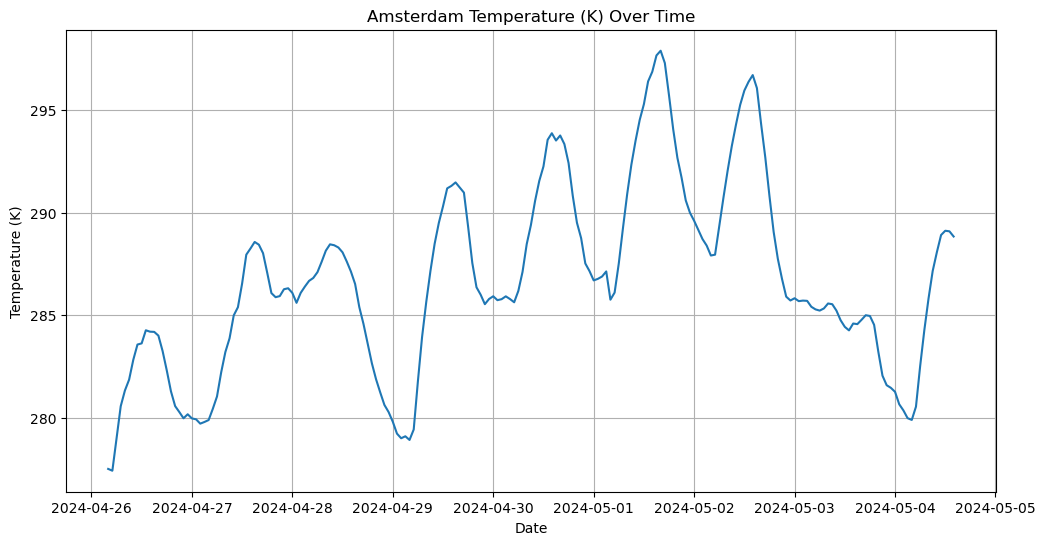

In [19]:
plt.figure(figsize = (12, 6))
plt.plot(ams_ts.index, ams_ts['t2m'])
plt.title("Amsterdam Temperature (K) Over Time")
plt.xlabel("Date")
plt.ylabel("Temperature (K)")
plt.grid(True)

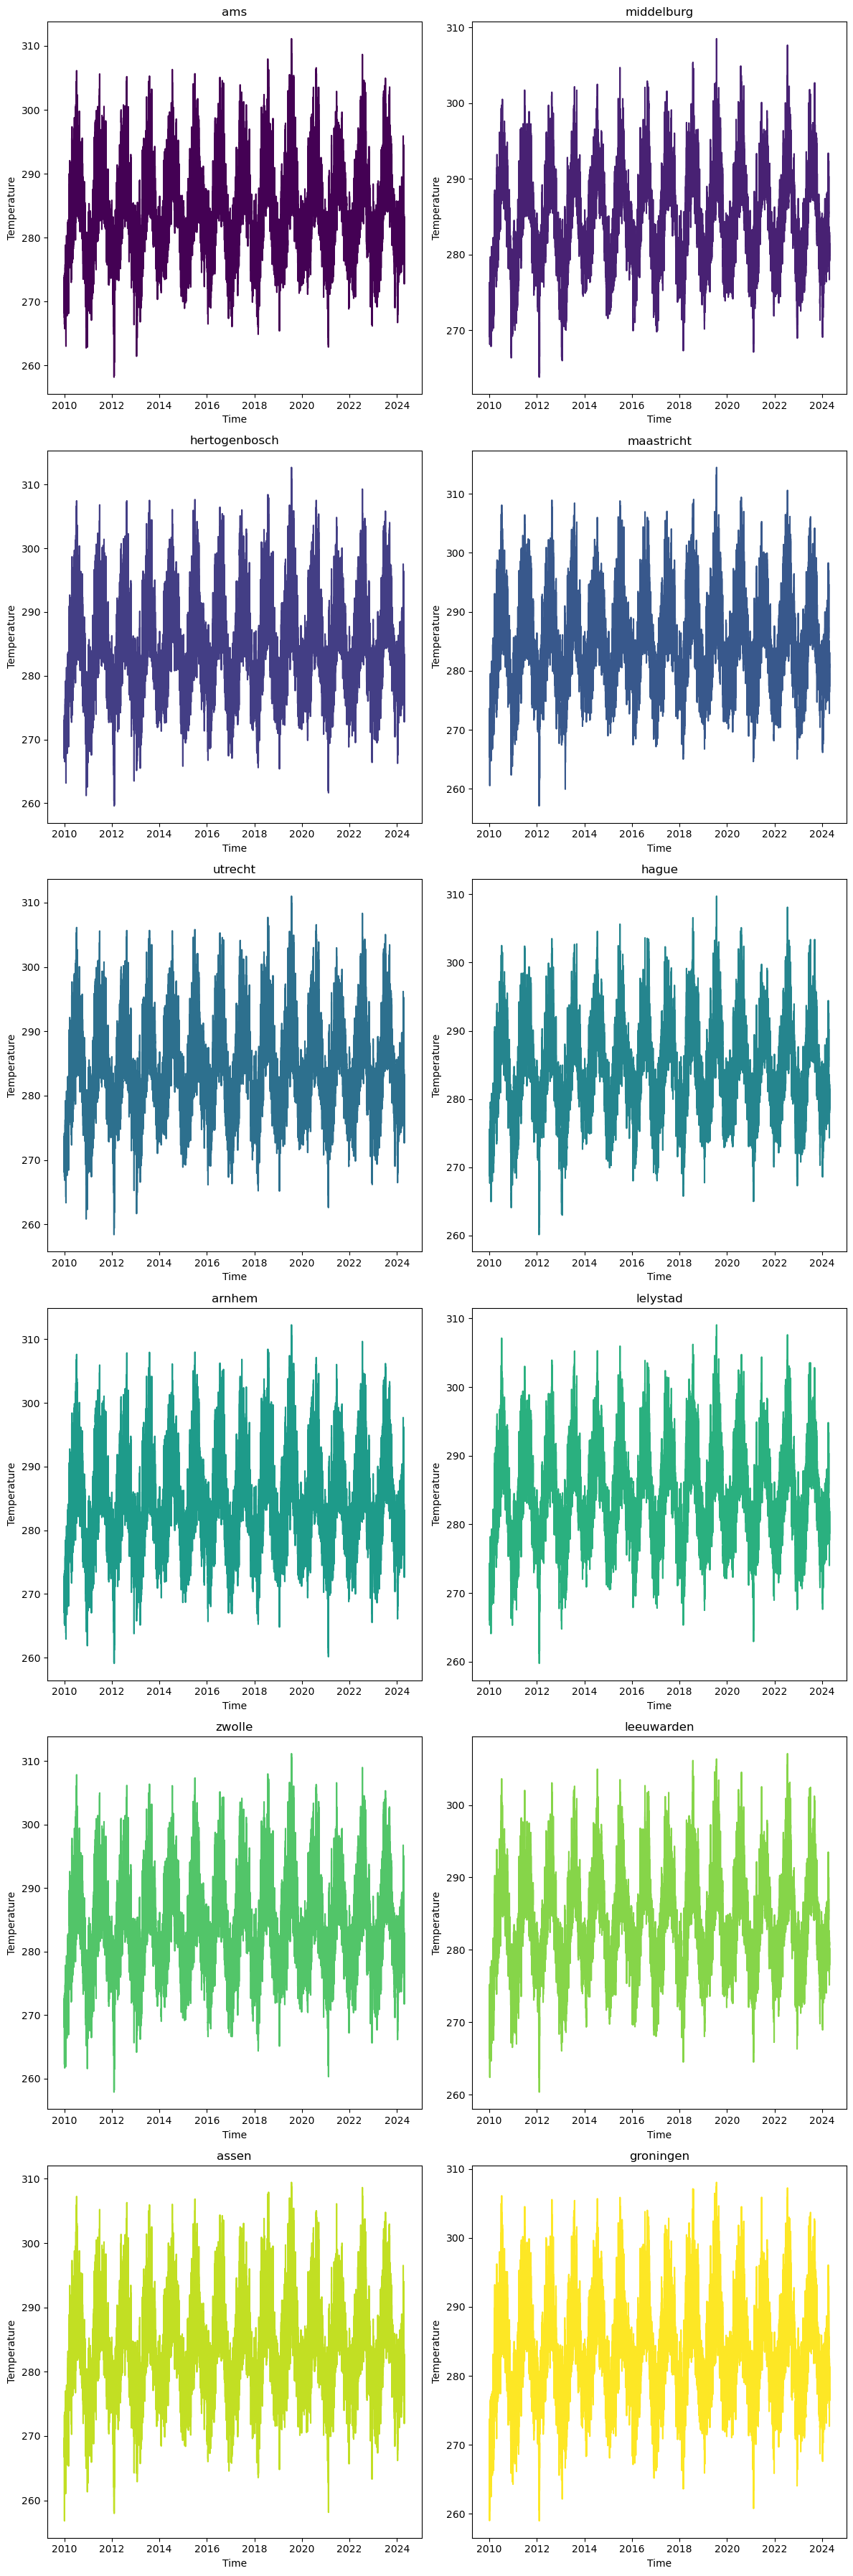

In [116]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# Example: dataframes_tr = [city1_df, city2_df, city3_df, ...]
# Each DataFrame should have a 'time' column and 't2m' column (temperature).

num_cities = len(dataframes_tr)
num_cols = 2  # Number of columns in the subplot grid
num_rows = (num_cities + num_cols - 1) // num_cols  # Calculate number of rows needed

fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 6 * num_rows))

# Generate a list of colors from a colormap
colors = cm.viridis(np.linspace(0, 1, num_cities))

for i, (city, color) in enumerate(zip(dataframes_tr, colors)):
    row = i // num_cols
    col = i % num_cols

    # Assuming 'time' is a column and 't2m' is the temperature column
    # Convert 'time' column to datetime if it's not already
    if not np.issubdtype(city.index.dtype, np.datetime64):
        city.index = pd.to_datetime(city.index)

    axs[row, col].plot(city.index, city['t2m'], color=color)
    axs[row, col].set_title(df_names[i])
    axs[row, col].set_xlabel('Time')
    axs[row, col].set_ylabel('Temperature')

# If the number of cities is not a perfect multiple of the number of columns,
# hide any empty subplots
for j in range(i + 1, num_rows * num_cols):
    fig.delaxes(axs.flatten()[j])

plt.tight_layout()
plt.show()

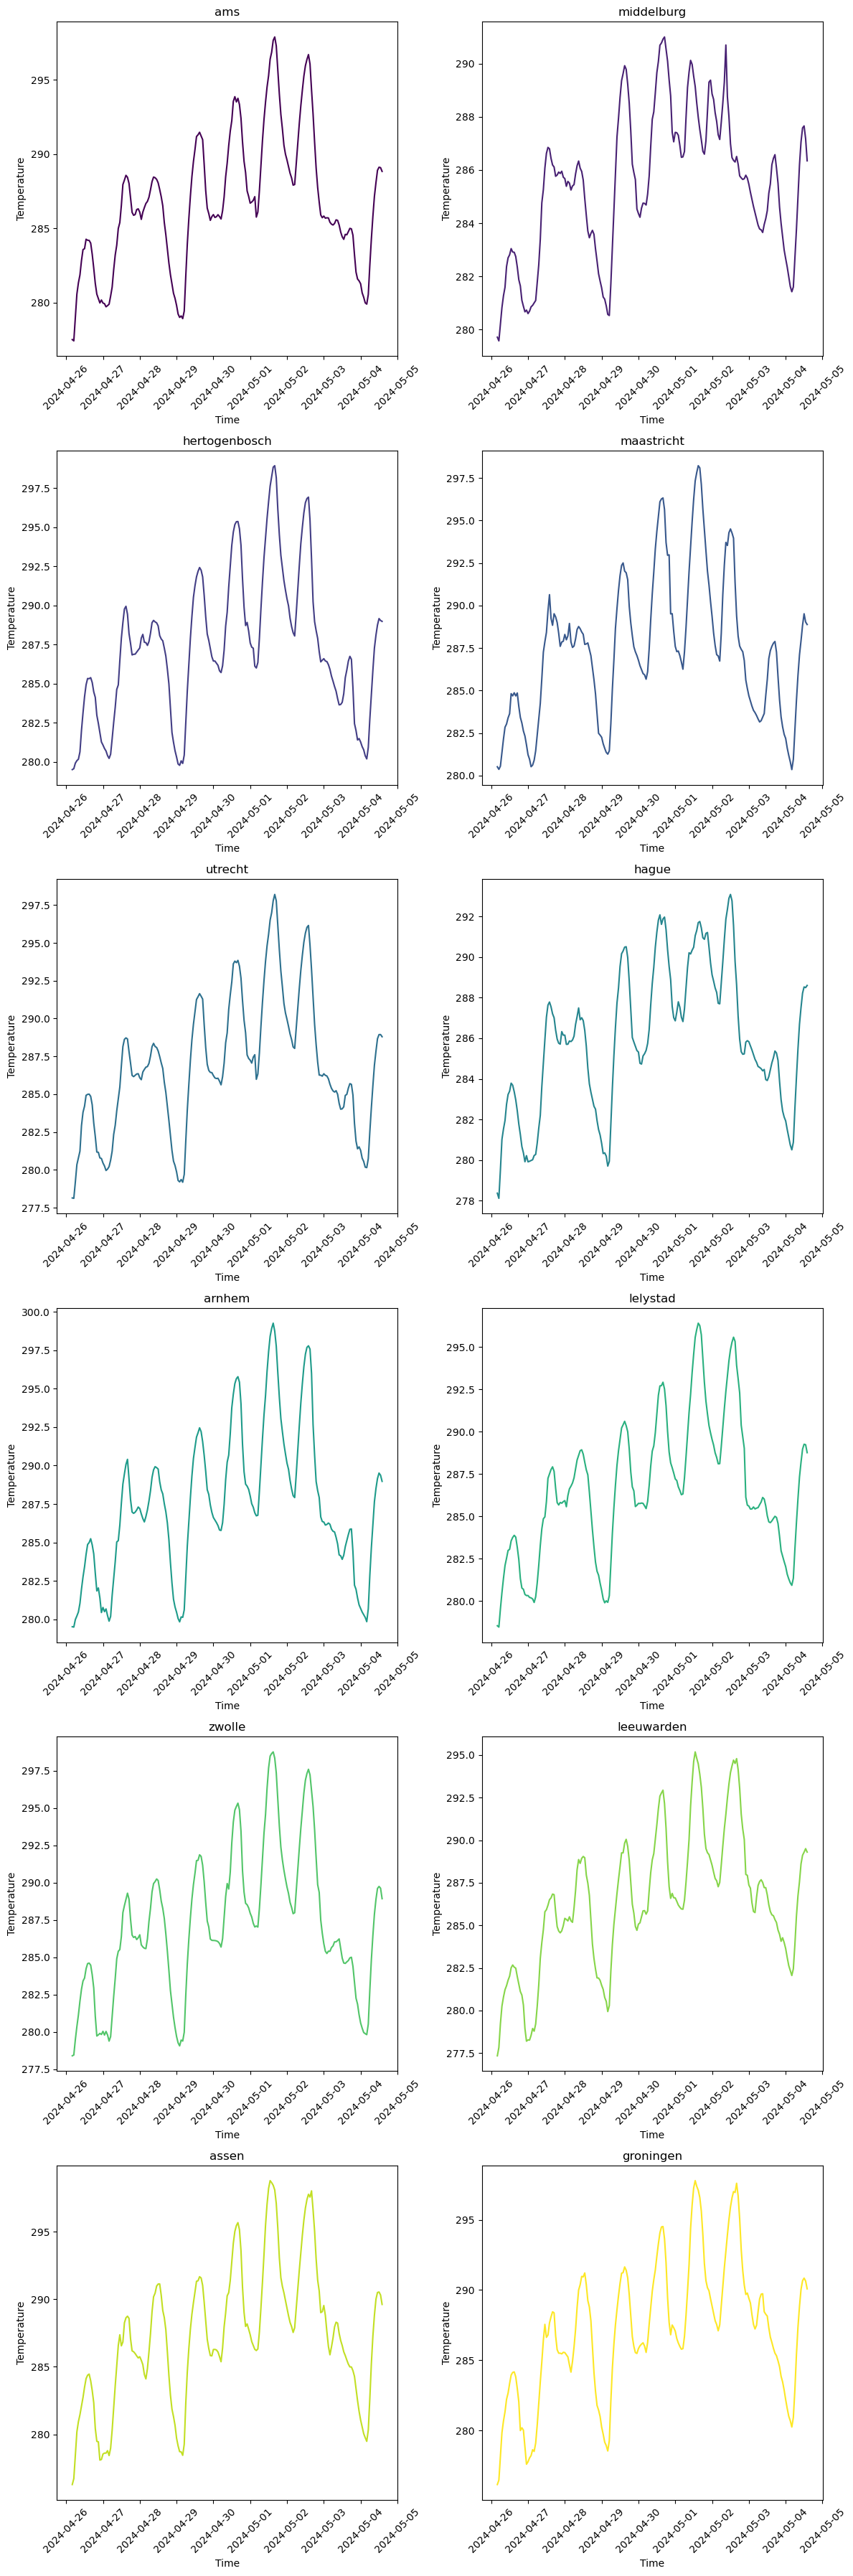

In [117]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd

# Example: dataframes_ts = [city1_df, city2_df, city3_df, ...]
# Each DataFrame should have a 'time' column and 't2m' column (temperature).

num_cities = len(dataframes_ts)
num_cols = 2  # Number of columns in the subplot grid
num_rows = (num_cities + num_cols - 1) // num_cols  # Calculate number of rows needed

fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 6 * num_rows))

# Generate a list of colors from a colormap
colors = cm.viridis(np.linspace(0, 1, num_cities))

for i, (city, color) in enumerate(zip(dataframes_ts, colors)):
    row = i // num_cols
    col = i % num_cols
    
    # Assuming 'time' is a column and 't2m' is the temperature column
    # Convert 'time' column to datetime if it's not already
    if not np.issubdtype(city.index.dtype, np.datetime64):
        city.index = pd.to_datetime(city.index)
    
    axs[row, col].plot(city.index, city['t2m'], color=color)
    axs[row, col].set_title(df_names[i])
    axs[row, col].set_xlabel('Time')
    axs[row, col].set_ylabel('Temperature')
    # Tilt the x-axis labels
    for tick in axs[row, col].get_xticklabels():
        tick.set_rotation(45)

# If the number of cities is not a perfect multiple of the number of columns,
# hide any empty subplots
for j in range(i + 1, num_rows * num_cols):
    fig.delaxes(axs.flatten()[j])

plt.tight_layout()
plt.show()

In [20]:
X_test_df = {}
Y_test_df = {}

for i, city in enumerate(dataframes_ts):
    df = city.copy()

    X_test = df[['t2m', 'u10', 'v10', 'd2m', 'tcc', 'tp']]
    # , 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12']]
    Y_test = df['t2m']

    scaler = MinMaxScaler()
    # X_test = X_test.values.reshape(-1, 1)
    X_test_scaled = scaler.fit_transform(X_test)
    Y_test = Y_test.values.reshape(-1, 1)
    Y_test_scaled = scaler.fit_transform(Y_test)

    X_test_tensor, Y_test_tensor = create_sequences(X_test_scaled, Y_test_scaled, timestep)

    X_test_df[df_names[i]] = X_test_tensor
    Y_test_df[df_names[i]] = Y_test_tensor

# 2 different approaches

- transfer learning

- separate models for each city

In [21]:
i = 'ams'

# Define your tensorXtrain, tensorYtrain, tensorXvalid, tensorYvalid, tensorXtest, and scaledYtest here
tensorXtrain = X_train_df[i]
tensorYtrain = Y_train_df[i]
tensorXvalid = X_valid_df[i]
tensorYvalid = Y_valid_df[i]
tensorXtest = X_test_df[i]
Y_test = ams_ts['t2m']

# Train the model
model = Sequential([
    Bidirectional(LSTM(256, return_sequences=True), input_shape=(tensorXtrain.shape[1], tensorXtrain.shape[2])),
    Dropout(0.2),
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.2),
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.2),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.2),
    Bidirectional(LSTM(32, return_sequences=False)),
    Dropout(0.2),
    Dense(1)
])

optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='mae')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model.fit(tensorXtrain, tensorYtrain, epochs=200, batch_size=128, validation_data=(tensorXvalid, tensorYvalid), callbacks=[early_stopping])

2024-06-15 15:23:32.993956: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2024-06-15 15:23:32.994058: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-06-15 15:23:32.994073: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-06-15 15:23:32.994663: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-15 15:23:32.994999: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/200


2024-06-15 15:23:39.713737: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-15 15:23:40.573142: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-15 15:23:40.608421: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-15 15:23:42.006743: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-15 15:23:42.022396: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-15 15:23:43.311059: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-15 15:23:43.326359: I tensorflow/core/grappler/optimizers/cust

785/785 [==============================] - ETA: 0s - loss: 0.0369

2024-06-15 15:25:01.301360: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-15 15:25:01.568229: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-15 15:25:01.568249: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-15 15:25:02.685249: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-15 15:25:02.696615: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-15 15:25:03.856280: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-15 15:25:03.867237: I tensorflow/core/grappler/optimizers/cust

785/785 [==============================] - 97s 92ms/step - loss: 0.0369 - val_loss: 0.0286
Epoch 2/200
785/785 [==============================] - 61s 77ms/step - loss: 0.0202 - val_loss: 0.0224
Epoch 3/200
785/785 [==============================] - 62s 79ms/step - loss: 0.0173 - val_loss: 0.0174
Epoch 4/200
785/785 [==============================] - 62s 79ms/step - loss: 0.0152 - val_loss: 0.0154
Epoch 5/200
785/785 [==============================] - 59s 75ms/step - loss: 0.0141 - val_loss: 0.0173
Epoch 6/200
785/785 [==============================] - 60s 77ms/step - loss: 0.0135 - val_loss: 0.0146
Epoch 7/200
785/785 [==============================] - 60s 76ms/step - loss: 0.0131 - val_loss: 0.0146
Epoch 8/200
785/785 [==============================] - 60s 76ms/step - loss: 0.0129 - val_loss: 0.0134
Epoch 9/200
785/785 [==============================] - 59s 75ms/step - loss: 0.0125 - val_loss: 0.0132
Epoch 10/200
785/785 [==============================] - 59s 75ms/step - loss: 0.0122 

2024-06-15 16:05:27.926238: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-15 16:05:28.236574: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-15 16:05:28.248037: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-15 16:05:29.337119: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-15 16:05:29.348329: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-15 16:05:30.439034: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-15 16:05:30.449974: I tensorflow/core/grappler/optimizers/cust

6/6 [==============================] - 8s 322ms/step


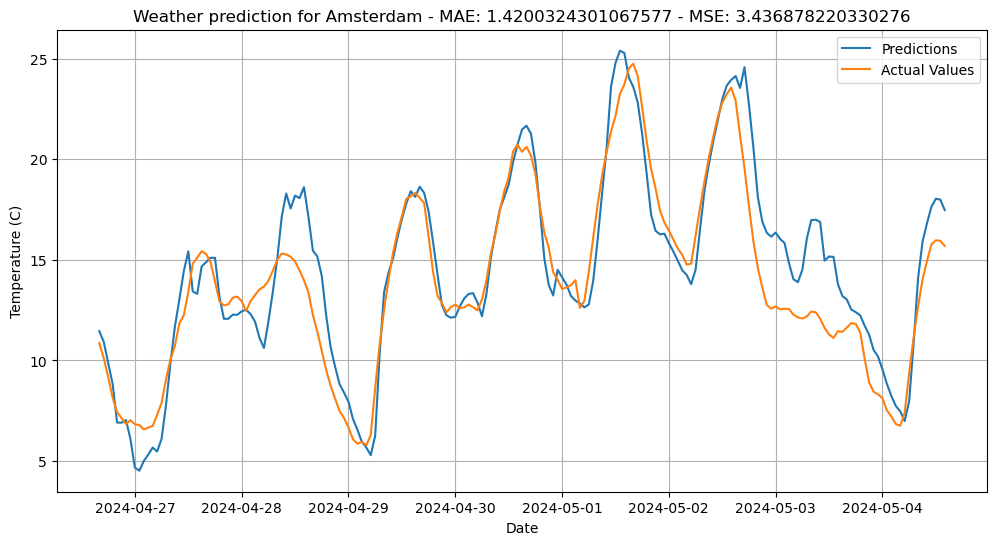

In [22]:
true_predict = scaler.inverse_transform(model.predict(X_test_tensor))

mae = mean_absolute_error(Y_test[-len(true_predict):], true_predict)
mse = mean_squared_error(Y_test[-len(true_predict):], true_predict)

plt.figure(figsize = (12, 6))
plt.plot(Y_test.index[-len(true_predict):], true_predict - 273.15, label = "Predictions")
plt.plot(Y_test[-len(true_predict):] - 273.15, label = "Actual Values")
plt.title(f"Weather prediction for Amsterdam - MAE: {mae} - MSE: {mse}")
plt.ylabel("Temperature (C)")
plt.xlabel("Date")
plt.grid(True)
plt.legend()

# SHAP

In [40]:
explainer = shap.DeepExplainer(model, X_train_tensor[:500])

# Select a subset of the data to explain (e.g., the first 500 samples from training data)
X_explain = X_train_tensor[:500]

# Generate SHAP values
shap_values = explainer.shap_values(X_explain)

# Plot the SHAP values
shap.summary_plot(shap_values[0], X_explain)

TypeError: Tensors are unhashable (this tensor: KerasTensor(type_spec=TensorSpec(shape=(?, 12, 6), dtype=tf.float32, name='bidirectional_input'), name='bidirectional_input', description="created by layer 'bidirectional_input'")). Instead, use tensor.ref() as the key.

# FORECAST

1/1 [==============================] - 0s 25ms/step


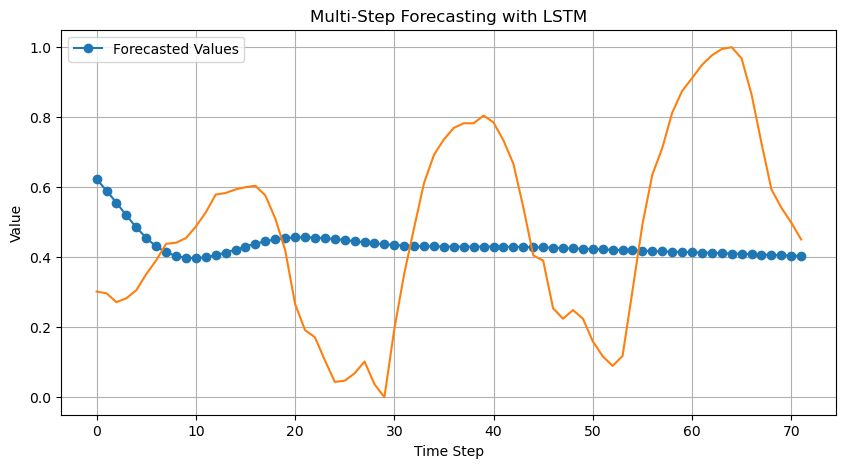

In [33]:
# Example: Replace with your actual test data and model
n_lookback = 12  # Length of input sequences for forecasting
forecast_steps = 72  # Number of steps to forecast ahead

# Assuming scaler is your MinMaxScaler used for scaling data (replace with your actual scaler)
scaler = MinMaxScaler()  # Your MinMaxScaler

# Initialize the forecasting process
X_ = Y_test_scaled[-n_lookback:]  # Last available input sequence from test data
forecast = []

# Forecasting loop
for _ in range(forecast_steps):
    X_ = X_.reshape(1, n_lookback, 1)  # Reshape for LSTM input (samples, time steps, features)

    # Predict the next value
    Y_ = model.predict(X_)
    # Y_ = scaler.inverse_transform(Y_.reshape(-1, 1))  # Inverse transform to original scale

    # Append the predicted value to the forecast list
    forecast.append(Y_[0, 0])

    # Update the input sequence for the next prediction
    X_ = np.append(X_.flatten()[1:], Y_[-1])  # Shift and append the latest prediction

forecast_df = pd.read_csv('/Users/lpaggen/Documents/DACS COURSES/Project2-2/Project_2-2/NL_data/forecast/forecast.csv')

forecast_df.set_index('time', inplace = True, drop = True)
forecast_ams = forecast_df[(forecast_df['latitude'] == 52.25) & (forecast_df['longitude'] == 5.)]

Y_forecast = forecast_ams['t2m'][forecast_steps:].values

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(forecast, label='Forecasted Values', marker='o')
plt.plot(scaler.fit_transform(Y_forecast[:forecast_steps].reshape(-1, 1)))
plt.title('Multi-Step Forecasting with LSTM')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
predictions_dict = {} # store model predictions
predictions_unseen = {}

for i in df_names:

    tensorXtrain = X_train_df[i]
    tensorYtrain = Y_train_df[i]
    tensorXvalid = X_valid_df[i]
    tensorYvalid = Y_valid_df[i]

    # Define model
    model = Sequential()
    model.add(LSTM(128, input_shape = (timestep, tensorXtrain.shape[2]), return_sequences = True))
    model.add(Dropout(0.2))

    model.add(LSTM(64, return_sequences = True))  # have to set to false if last layer
    model.add(Dropout(0.2))
    
    model.add(LSTM(64, return_sequences = True))  # have to set to false if last layer
    model.add(Dropout(0.2))

    model.add(LSTM(128, return_sequences = False))  # have to set to false if last layer
    model.add(Dropout(0.1))

    model.add(Dense(1)) # dense is your output

    # really we are free to try antyhing here, it just takes countless hours to even get something that works better in city A and B etc
    optimizer = Adam(learning_rate = 0.01) # anything works, adam is fine, sgd really good
    model.compile(optimizer = optimizer, loss = 'mae') # huber works well

    # need early stopping to avoid the overfitting
    early_stopping = EarlyStopping(monitor = 'val_loss', patience = 15, restore_best_weights = True)

    model.fit(tensorXtrain, tensorYtrain, epochs = 100, batch_size=64, validation_data = (tensorXvalid, tensorYvalid), callbacks = early_stopping)

    # predictions = model.predict(tensorXvalid)

    # predictions_dict[i] = predictions

    # save the model, so we can load them and predict on them quickly for the presentation of the final results
    save_dir = os.path.join("/Users/lpaggen/Documents/DACS COURSES/Project2-2/Project_2-2/Python/LSTM/my_dir/models", i)
    model.save(save_dir)

    # here we shift to the test data, things can be done here but it is VERY HARD to optimize <- it just sucks hard
    # tensorXtest = X_test_df[i]
    # test_predict = model.predict(tensorXtest)

    # prediction_copies = np.repeat(test_predict, timestep - 1, axis = -1)
    # true_predict = scaler.inverse_transform(test_predict)

    # predictions_unseen[i] = true_predict

    K.clear_session()
    gc.collect()

Epoch 1/100


2024-05-24 12:57:21.492321: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-24 12:57:21.864975: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-24 12:57:22.788322: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-24 12:57:23.585914: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-24 12:57:24.365129: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-24 12:57:25.907618: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-24 12:57:27.355759: I tensorflow/core/grappler/optimizers/cust

63/64 [============================>.] - ETA: 0s - loss: 0.1892

KeyboardInterrupt: 

# LINEAR REGRESSION

In [75]:
lr_model = LinearRegression()

**LSTM NOTES**

-> using Adam doesn't give great results
-> using rmsprop gives better results

# ARIMA MODEL FOR FORECASTING

In [13]:
X_train = ams_tr['t2m'].values